
# Simple Methods Weighted Composite (Team Rule)



## 1) Setup

In [2]:

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Tuple, Dict
from pandas.tseries.offsets import BDay

# -------------------- Config --------------------
DATA_DIR = "../data/processed/single_stock_data_1"
OUTPUT_DIR = "../output-v3"
GLOB_PATTERN = "*.csv"
DATE_COL_CANDIDATES = ["Date","date","trade_date","datetime","time","日期"]
TARGET_COL_CANDIDATES = ["close","Close","CLOSE","收盘","收盘价"]
SPLIT_RATIO = 0.8        # 80% train, 20% test
M = 5                     # seasonal cycle (weekly business days)
FUTURE_H = 20             # future steps
ROLL_START_RATIO = 0.6

OUT_DIR = os.path.join(OUTPUT_DIR, "forecasts_aligned")
os.makedirs(OUT_DIR, exist_ok=True)
METRICS_PATH = os.path.join(OUTPUT_DIR, "forecast_metrics_summary_minmax.csv")
TOP10_PATH = os.path.join(OUTPUT_DIR, "top10_by_model_minmax.csv")
ALL_FORECASTS_PATH = os.path.join(OUTPUT_DIR, "all_forecasts_combined_aligned.csv")

W_RMSE, W_MAE, W_R2 = 0.4, 0.3, 0.3

FILES = sorted(glob.glob(os.path.join(DATA_DIR, GLOB_PATTERN)))
print(f"Found {len(FILES)} csv file(s). Example: {FILES[:5]}")


Found 50 csv file(s). Example: ['../data/processed/single_stock_data_1\\000063.csv', '../data/processed/single_stock_data_1\\000333.csv', '../data/processed/single_stock_data_1\\000617.csv', '../data/processed/single_stock_data_1\\000725.csv', '../data/processed/single_stock_data_1\\000792.csv']


## 2) Utilities & Simple Models (log domain)

In [4]:

def detect_cols(df: pd.DataFrame):
    # date col
    date_col = None
    for c in df.columns:
        if c in DATE_COL_CANDIDATES or c.strip().lower() in [x.lower() for x in DATE_COL_CANDIDATES]:
            date_col = c; break
    if date_col is None: date_col = df.columns[0]
    # target col
    target_col = None
    for c in df.columns:
        if c in TARGET_COL_CANDIDATES or c.strip().lower() in [x.lower() for x in TARGET_COL_CANDIDATES]:
            target_col = c; break
    if target_col is None:
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        target_col = num_cols[-1] if num_cols else df.columns[-1]
    return date_col, target_col

def parse_series(df: pd.DataFrame) -> Tuple[pd.Series, str, str]:
    date_col, target_col = detect_cols(df)
    out = (
        df[[date_col, target_col]]
        .dropna()
        .assign(**{date_col: lambda x: pd.to_datetime(x[date_col], errors="coerce")})
        .dropna(subset=[date_col])
        .sort_values(date_col)
    )
    y = pd.to_numeric(out[target_col].astype(str).str.replace(",", "").str.strip(), errors="coerce")
    s = pd.Series(y.values, index=out[date_col].values, name=target_col).dropna()
    s = s[s > 0]  # positivity for log
    return s, date_col, target_col

def split_by_ratio(y: pd.Series, ratio: float):
    n = len(y); k = max(1, int(n * ratio))
    return y.iloc[:k], y.iloc[k:]

# simple models (log)
def mean_forecast_log(train_log, h): return np.full(h, float(train_log.mean()))
def naive_forecast_log(train_log, h): return np.full(h, float(train_log.iloc[-1]))
def seasonal_naive_forecast_log(train_log, h, m):
    if len(train_log) < m: return naive_forecast_log(train_log, h)
    last_season = train_log.iloc[-m:]
    reps = int(np.ceil(h / m)); return np.tile(last_season.values, reps)[:h]
def drift_forecast_log(train_log, h):
    T=len(train_log); y1,yT=float(train_log.iloc[0]), float(train_log.iloc[-1])
    if T==1: return np.full(h, yT)
    slope=(yT-y1)/(T-1); steps=np.arange(1,h+1); return yT + slope*steps

# evaluation_metrics (original scale)
def r2_score(y_true, y_pred):
    y_true=np.asarray(y_true,float); y_pred=np.asarray(y_pred,float)
    ss_res=np.sum((y_true-y_pred)**2); ss_tot=np.sum((y_true-np.mean(y_true))**2)
    return np.nan if ss_tot==0 else 1.0-ss_res/ss_tot

def eval_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    err = y_true - y_pred
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    denom = np.where(y_true == 0, np.nan, np.abs(y_true))
    mape = float(np.nanmean(np.abs(err) / denom) * 100.0)
    r2 = float(r2_score(y_true, y_pred))
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

def make_future_bdays(last_index, h): 
    return pd.bdate_range(start=last_index[-1] + BDay(1), periods=h)


## 3) Per-file processing (80/20 split)

In [5]:

def process_file(path: str):
    base = os.path.splitext(os.path.basename(path))[0]
    df = pd.read_csv(path)
    y, date_col, target_col = parse_series(df)
    if len(y) < 20: raise ValueError("Series too short.")

    y_log = np.log(y)
    train_log, test_log = split_by_ratio(y_log, SPLIT_RATIO)
    h = len(test_log)
    truth = np.exp(test_log.values); test_index = test_log.index

    preds = {
        "mean": np.exp(mean_forecast_log(train_log, h)),
        "naive": np.exp(naive_forecast_log(train_log, h)),
        "seasonal_naive": np.exp(seasonal_naive_forecast_log(train_log, h, M)),
        "drift": np.exp(drift_forecast_log(train_log, h)),
    }

    results = []
    for name, pred in preds.items():
        met = eval_metrics(truth, pred)  # RMSE, MAE, MAPE, R2
        met.update({"file": base, "model": name, "test_points": int(h)})
        results.append(met)

    # forecasts (test + optional future)
    future_index = make_future_bdays(y.index, FUTURE_H)
    fc_future = {
        "mean": np.exp(mean_forecast_log(y_log, FUTURE_H)),
        "naive": np.exp(naive_forecast_log(y_log, FUTURE_H)),
        "seasonal_naive": np.exp(seasonal_naive_forecast_log(y_log, FUTURE_H, M)),
        "drift": np.exp(drift_forecast_log(y_log, FUTURE_H)),
    }

    fc_test_df = pd.DataFrame({
        "ds": np.tile(test_index, 4),
        "y": np.tile(truth, 4),
        "yhat": np.concatenate([preds["mean"], preds["naive"], preds["seasonal_naive"], preds["drift"]]),
        "model": np.repeat(["mean","naive","seasonal_naive","drift"], repeats=h),
        "file": base
    })
    fc_future_df = pd.DataFrame({
        "ds": np.tile(future_index, 4),
        "y": np.nan,
        "yhat": np.concatenate([fc_future["mean"], fc_future["naive"], fc_future["seasonal_naive"], fc_future["drift"]]),
        "model": np.repeat(["mean","naive","seasonal_naive","drift"], repeats=FUTURE_H),
        "file": base
    })

    out_path = os.path.join(OUT_DIR, f"{base}_forecasts.csv")
    pd.concat([fc_test_df, fc_future_df], ignore_index=True).to_csv(out_path, index=False)

    return pd.DataFrame(results), pd.concat([fc_test_df, fc_future_df], ignore_index=True)


## 4) Batch, per-model min–max, composite score & Top-10

In [6]:
# Batch processing: gather metrics and forecasts
all_metrics, all_forecasts = [], []
for fp in FILES:
    try:
        mdf, fdf = process_file(fp)
        all_metrics.append(mdf); all_forecasts.append(fdf)
        print(f"Processed: {os.path.basename(fp)}")
    except Exception as e:
        print(f"[WARN] Skipping {os.path.basename(fp)}: {e}")

metrics_df = pd.concat(all_metrics, ignore_index=True) if all_metrics else pd.DataFrame()
forecasts_df = pd.concat(all_forecasts, ignore_index=True) if all_forecasts else pd.DataFrame()

# keep minmax helper but we no longer use min-max normalization for scoring
def minmax_norm_by_group(s: pd.Series, grp: pd.Series) -> pd.Series:
    df = pd.DataFrame({"v": s, "g": grp})
    mins = df.groupby("g")["v"].transform("min")
    maxs = df.groupby("g")["v"].transform("max")
    rng = maxs - mins
    return np.where(rng == 0, 0.5, (df["v"] - mins) / rng)

# New scoring: weighted combination of raw RMSE (cost), MAE (cost) and R2 (benefit)
if not metrics_df.empty:
    metrics_df["WeightedScore"] = (
        -metrics_df["RMSE"] * W_RMSE
        -metrics_df["MAE"] * W_MAE
        + metrics_df["R2"].fillna(0.0) * W_R2
    )

    metrics_df.to_csv(METRICS_PATH, index=False)
    display(metrics_df.sort_values(["model","WeightedScore"], ascending=[True, False]).groupby("model").head(5))

# Top-10 per model by WeightedScore
if not metrics_df.empty:
    top_list = []
    for name, g in metrics_df.groupby("model", as_index=False):
        g_sorted = g.sort_values("WeightedScore", ascending=False).head(10).copy()
        g_sorted["rank"] = range(1, len(g_sorted)+1)
        top_list.append(g_sorted[["model","rank","file","WeightedScore","RMSE","MAE","MAPE","R2","test_points"]])
    top10_df = pd.concat(top_list, ignore_index=True)
    top10_df.to_csv(TOP10_PATH, index=False)
    display(top10_df)

if not forecasts_df.empty:
    forecasts_df.to_csv(ALL_FORECASTS_PATH, index=False)

print("Saved:")
print(" - metrics:", METRICS_PATH, f"(exists={os.path.exists(METRICS_PATH)})")
print(" - top10:", TOP10_PATH, f"(exists={os.path.exists(TOP10_PATH)})")
print(" - forecasts:", ALL_FORECASTS_PATH, f"(exists={os.path.exists(ALL_FORECASTS_PATH)})")
print("Per-file forecasts are in:", OUT_DIR)


Processed: 000063.csv
Processed: 000333.csv
Processed: 000617.csv
Processed: 000725.csv
Processed: 000792.csv
Processed: 000938.csv
Processed: 002027.csv
Processed: 002230.csv
Processed: 002371.csv
Processed: 002475.csv
Processed: 002371.csv
Processed: 002475.csv
Processed: 002594.csv
Processed: 002714.csv
Processed: 300015.csv
Processed: 300124.csv
Processed: 300408.csv
Processed: 300750.csv
Processed: 300760.csv
Processed: 600009.csv
Processed: 002594.csv
Processed: 002714.csv
Processed: 300015.csv
Processed: 300124.csv
Processed: 300408.csv
Processed: 300750.csv
Processed: 300760.csv
Processed: 600009.csv
Processed: 600019.csv
Processed: 600028.csv
Processed: 600030.csv
Processed: 600031.csv
Processed: 600019.csv
Processed: 600028.csv
Processed: 600030.csv
Processed: 600031.csv
Processed: 600036.csv
Processed: 600048.csv
Processed: 600111.csv
Processed: 600276.csv
Processed: 600309.csv
Processed: 600406.csv
Processed: 600415.csv
Processed: 600426.csv
Processed: 600036.csv
Processed:

,RMSE,MAE,MAPE,R2,file,model,test_points,WeightedScore
175,0.612379,0.450223,5.858444,-0.964825,601766,drift,247,-0.669466
167,0.829987,0.677522,9.446805,-1.224300,601600,drift,247,-0.902541
187,2.108411,1.368954,6.862619,0.409220,601899,drift,247,-1.131285
179,0.446048,0.391792,6.872189,-2.967737,601816,drift,247,-1.186278
95,1.397620,1.203947,13.352434,-1.312206,600048,drift,247,-1.313894
12,0.249448,0.203612,5.066426,-0.196451,000725,mean,247,-0.219798
84,1.712777,1.382222,7.707883,-0.020594,600031,mean,247,-1.105955
24,1.102350,0.943157,12.843626,-2.562431,002027,mean,247,-1.492617
136,1.976845,1.673166,6.238265,-2.390007,600887,mean,247,-2.009690
8,2.800306,2.348938,27.984605,-2.373935,000617,mean,247,-2.536984


,model,rank,file,WeightedScore,RMSE,MAE,MAPE,R2,test_points
0,drift,1,601766,-0.669466,0.612379,0.450223,5.858444,-0.964825,247
1,drift,2,601600,-0.902541,0.829987,0.677522,9.446805,-1.224300,247
2,drift,3,601899,-1.131285,2.108411,1.368954,6.862619,0.409220,247
3,drift,4,601816,-1.186278,0.446048,0.391792,6.872189,-2.967737,247
4,drift,5,600048,-1.313894,1.397620,1.203947,13.352434,-1.312206,247
5,drift,6,600900,-1.339135,1.532724,1.202108,4.353252,-1.218044,247
6,drift,7,000725,-1.840375,0.553072,0.515523,12.250480,-4.881629,247
7,drift,8,000792,-1.960636,2.277322,1.474521,7.919033,-2.024504,201
8,drift,9,600426,-2.081058,2.764505,2.081712,8.789899,-1.169143,247
9,drift,10,601668,-2.682232,0.771427,0.717315,12.749805,-7.194890,247


Saved:
 - metrics: mnt/output-v3\forecast_metrics_summary_minmax.csv (exists=True)
 - top10: mnt/output-v3\top10_by_model_minmax.csv (exists=True)
 - forecasts: mnt/output-v3\all_forecasts_combined_aligned.csv (exists=True)
Per-file forecasts are in: mnt/output-v3\forecasts_aligned


--- Plotting top 3 for model: mean ---
File: 000725 | model: mean | WeightedScore=-0.219798 | test_points=247
  stored MAE, RMSE: 0.20361245130412203 0.24944839019827192
  recomputed MAE, RMSE: 0.20361245130412203 0.24944839019827192
  sample truth[:5]: [3.8313 3.8411 3.9201 4.0979 4.4138]
  sample pred [:5]: [4.23563193 4.23563193 4.23563193 4.23563193 4.23563193]
Saved plot: mnt/output-v3\plots_examples\mean_top1_000725.png
Saved plot: mnt/output-v3\plots_examples\mean_top1_000725.png


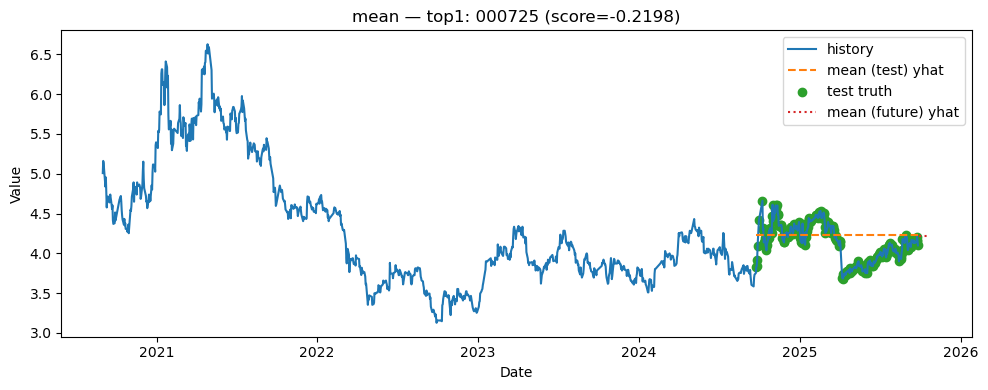

File: 600031 | model: mean | WeightedScore=-1.105955 | test_points=247
  stored MAE, RMSE: 1.3822215740500143 1.7127766512853138
  recomputed MAE, RMSE: 1.3822215740500143 1.7127766512853138
  sample truth[:5]: [16.3399 16.3693 16.8496 17.4671 18.5061]
  sample pred [:5]: [18.59059797 18.59059797 18.59059797 18.59059797 18.59059797]
Saved plot: mnt/output-v3\plots_examples\mean_top2_600031.png
Saved plot: mnt/output-v3\plots_examples\mean_top2_600031.png


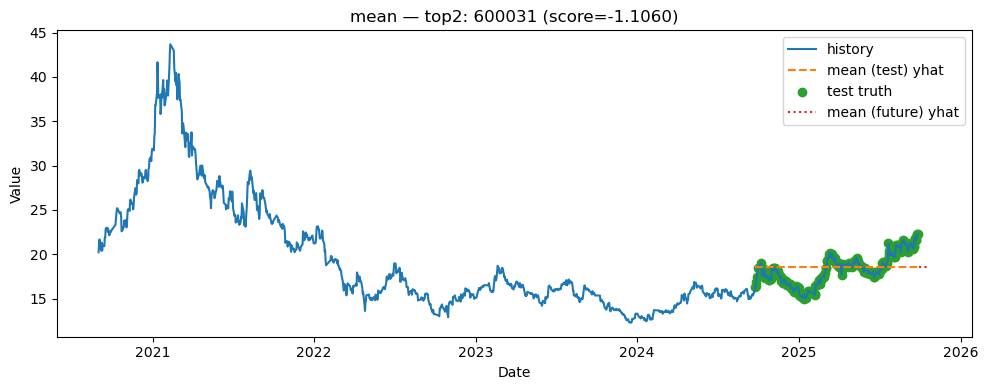

File: 002027 | model: mean | WeightedScore=-1.492617 | test_points=247
  stored MAE, RMSE: 0.9431571159118957 1.1023502092260768
  recomputed MAE, RMSE: 0.9431571159118957 1.1023502092260768
  sample truth[:5]: [5.6175 5.5984 6.0941 6.3371 6.8717]
  sample pred [:5]: [6.10927134 6.10927134 6.10927134 6.10927134 6.10927134]
Saved plot: mnt/output-v3\plots_examples\mean_top3_002027.png


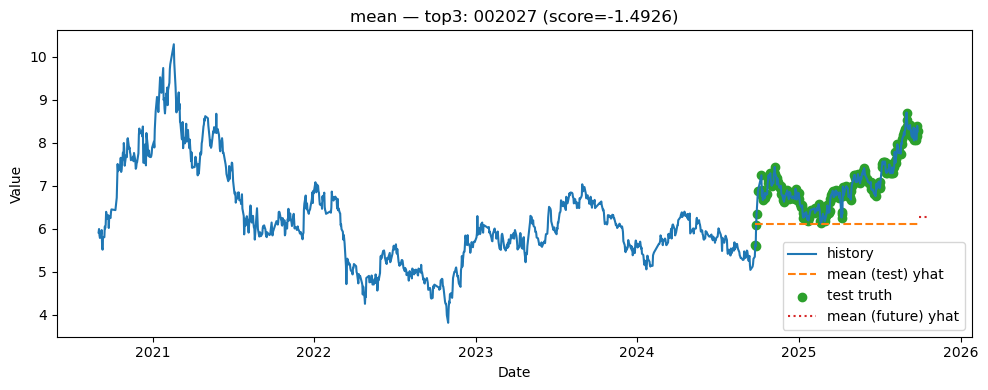

--- Plotting top 3 for model: naive ---
File: 601600 | model: naive | WeightedScore=-0.769929 | test_points=247
  stored MAE, RMSE: 0.6528210526315784 0.7656359118234224
  recomputed MAE, RMSE: 0.6528210526315784 0.7656359118234224
  sample truth[:5]: [7.0484 7.1845 7.622  7.9039 8.6525]
  sample pred [:5]: [6.8053 6.8053 6.8053 6.8053 6.8053]
Saved plot: mnt/output-v3\plots_examples\naive_top1_601600.png


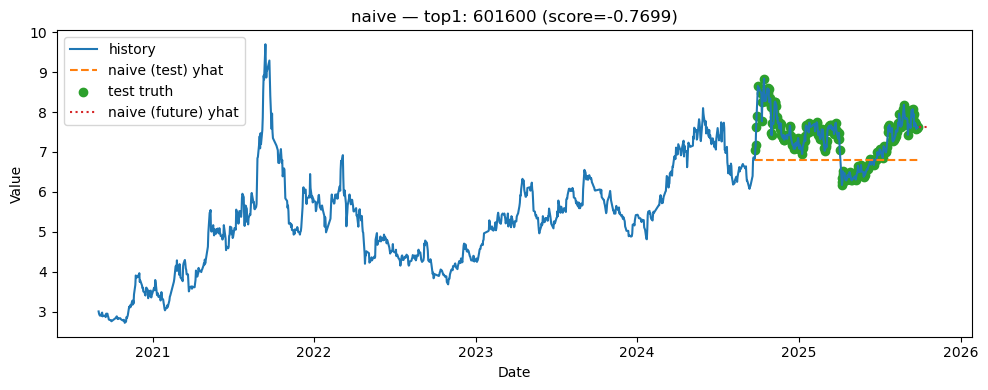

File: 600048 | model: naive | WeightedScore=-0.867877 | test_points=247
  stored MAE, RMSE: 0.7475186234817809 1.1614520473700496
  recomputed MAE, RMSE: 0.7475186234817809 1.1614520473700496
  sample truth[:5]: [ 7.9962  8.1136  8.926   9.8166 10.7953]
  sample pred [:5]: [7.9081 7.9081 7.9081 7.9081 7.9081]
Saved plot: mnt/output-v3\plots_examples\naive_top2_600048.png


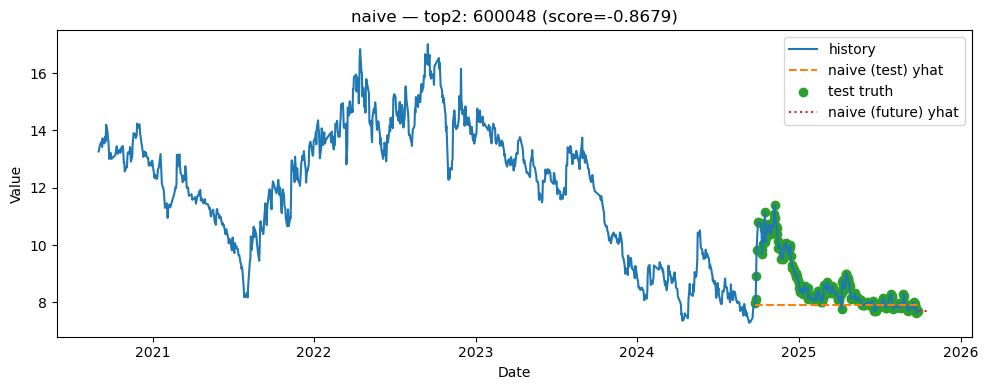

File: 601816 | model: naive | WeightedScore=-0.885255 | test_points=247
  stored MAE, RMSE: 0.32774453441295526 0.39411567677543835
  recomputed MAE, RMSE: 0.32774453441295526 0.39411567677543835
  sample truth[:5]: [5.2957 5.3642 5.4327 5.4915 5.9124]
  sample pred [:5]: [5.2663 5.2663 5.2663 5.2663 5.2663]
Saved plot: mnt/output-v3\plots_examples\naive_top3_601816.png
Saved plot: mnt/output-v3\plots_examples\naive_top3_601816.png


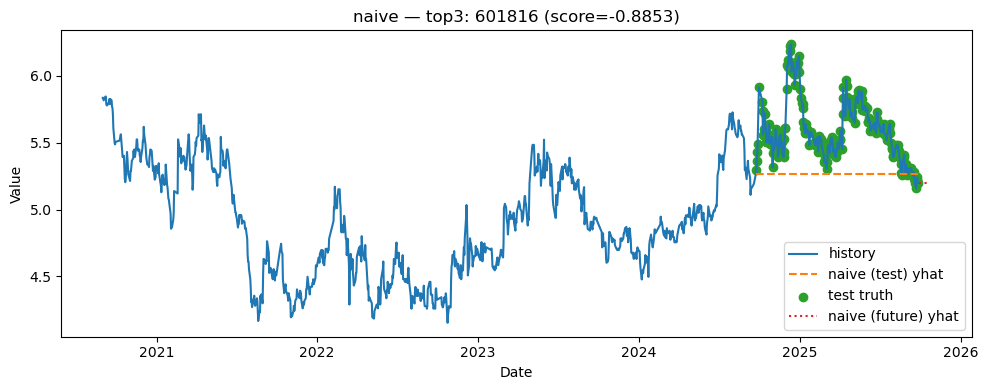

--- Plotting top 3 for model: seasonal_naive ---
File: 600028 | model: seasonal_naive | WeightedScore=-0.615477 | test_points=247
  stored MAE, RMSE: 0.404061133603239 0.464097898587878
  recomputed MAE, RMSE: 0.404061133603239 0.464097898587878
  sample truth[:5]: [6.4957 6.4572 6.4861 6.3996 6.6879]
  sample pred [:5]: [5.948  6.1402 6.0729 6.1305 6.2266]
Saved plot: mnt/output-v3\plots_examples\seasonal_naive_top1_600028.png


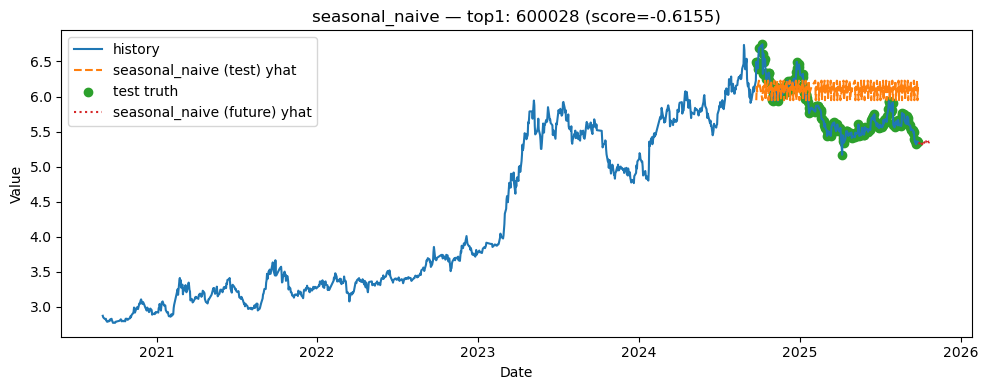

File: 600900 | model: seasonal_naive | WeightedScore=-0.915484 | test_points=247
  stored MAE, RMSE: 0.9815550607287441 1.2304514260804111
  recomputed MAE, RMSE: 0.9815550607287441 1.2304514260804111
  sample truth[:5]: [27.8571 28.0218 28.2155 28.0799 29.1066]
  sample pred [:5]: [27.4115 27.4309 27.4406 27.2662 27.3147]
Saved plot: mnt/output-v3\plots_examples\seasonal_naive_top2_600900.png


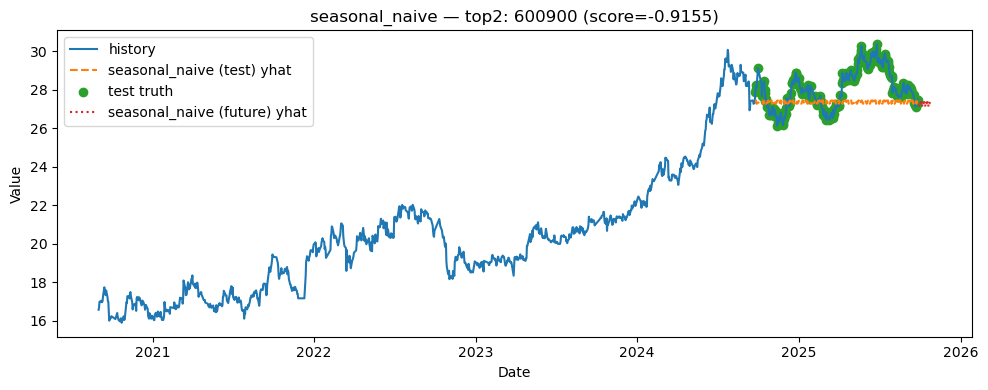

File: 000792 | model: seasonal_naive | WeightedScore=-1.013115 | test_points=201
  stored MAE, RMSE: 1.2987562189054722 1.4230184791631482
  recomputed MAE, RMSE: 1.2987562189054722 1.4230184791631482
  sample truth[:5]: [17.44 17.49 17.8  17.6  17.62]
  sample pred [:5]: [18.03 17.66 17.86 17.83 17.62]
Saved plot: mnt/output-v3\plots_examples\seasonal_naive_top3_000792.png


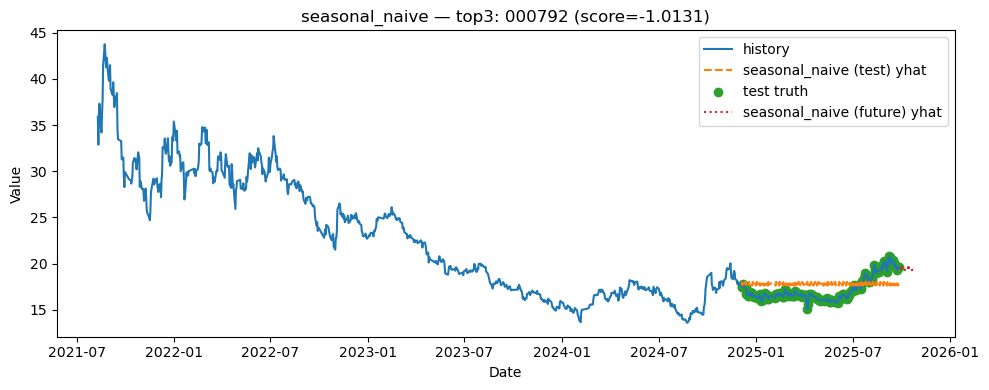

--- Plotting top 3 for model: drift ---
File: 601766 | model: drift | WeightedScore=-0.669466 | test_points=247
  stored MAE, RMSE: 0.45022344039793855 0.6123787162263962
  recomputed MAE, RMSE: 0.45022344039793855 0.6123787162263962
  sample truth[:5]: [7.1064 7.3106 7.4175 7.4369 7.9425]
  sample pred [:5]: [6.82662793 6.82875652 6.83088578 6.8330157  6.83514628]
Saved plot: mnt/output-v3\plots_examples\drift_top1_601766.png


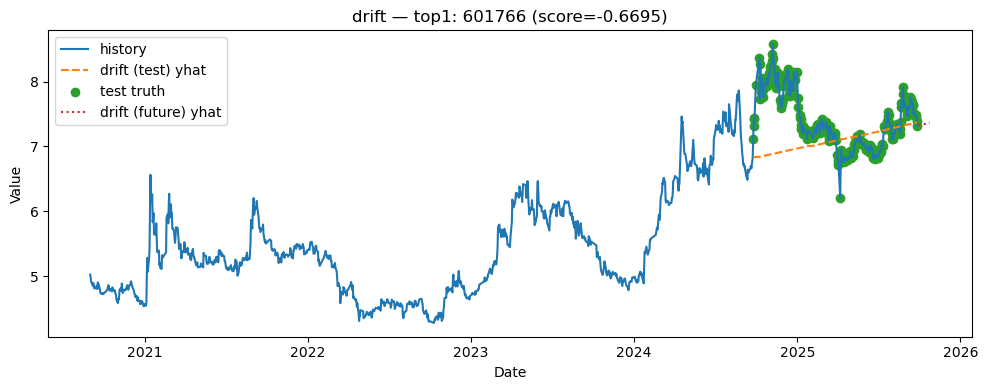

File: 601600 | model: drift | WeightedScore=-0.902541 | test_points=247
  stored MAE, RMSE: 0.67752239104099 0.82998665301419
  recomputed MAE, RMSE: 0.67752239104099 0.82998665301419
  sample truth[:5]: [7.0484 7.1845 7.622  7.9039 8.6525]
  sample pred [:5]: [6.81095516 6.81661501 6.82227957 6.82794884 6.83362282]
Saved plot: mnt/output-v3\plots_examples\drift_top2_601600.png


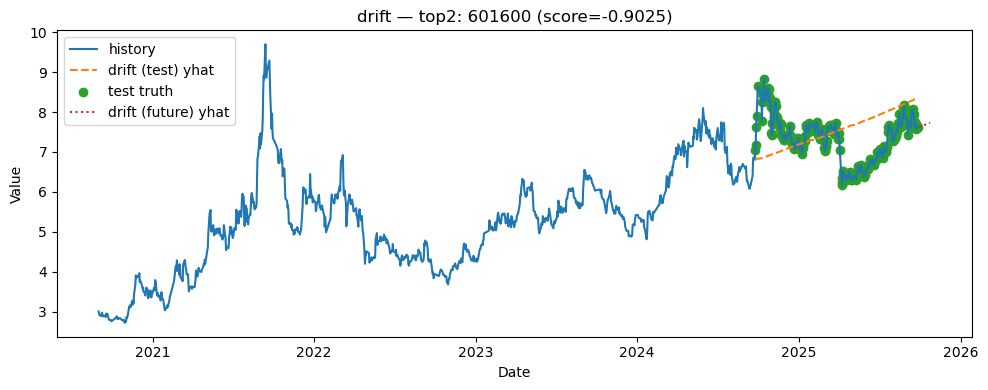

File: 601899 | model: drift | WeightedScore=-1.131285 | test_points=247
  stored MAE, RMSE: 1.3689542558225922 2.1084113393236454
  recomputed MAE, RMSE: 1.3689542558225922 2.1084113393236454
  sample truth[:5]: [16.2724 16.6765 17.1201 17.2581 17.879 ]
  sample pred [:5]: [15.60570073 15.61901281 15.63233625 15.64567105 15.65901722]
Saved plot: mnt/output-v3\plots_examples\drift_top3_601899.png


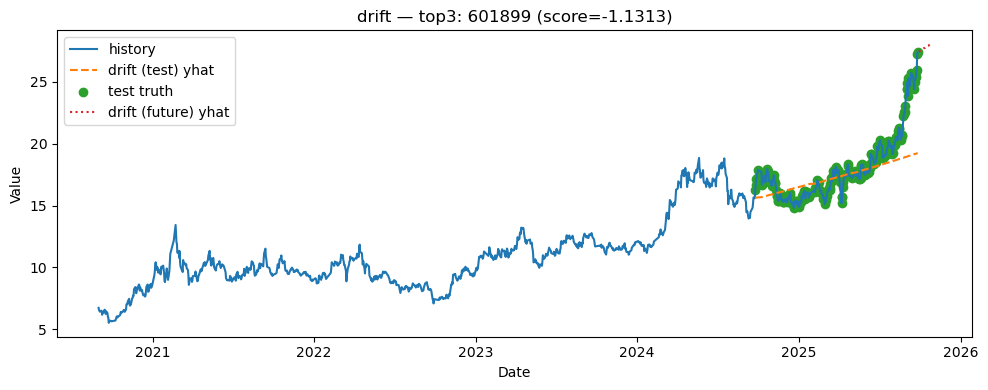

Plotting and diagnostics completed. Plots saved to: mnt/output-v3\plots_examples


In [7]:
# === 5) Plot Top-3 examples per model (by WeightedScore) with diagnostics ===
# For each simple model, pick top-3 files by WeightedScore, print diagnostics and plot history + test + future forecasts.
# Saves images to OUTPUT_DIR/plots_examples and displays them inline.

import math
from pathlib import Path

def recompute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    if y_true.size == 0:
        return { 'MAE': np.nan, 'RMSE': np.nan }
    err = y_true - y_pred
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    return { 'MAE': mae, 'RMSE': rmse }


def plot_top_examples(metrics_df: pd.DataFrame, forecasts_df: pd.DataFrame, data_dir: str, output_dir: str, top_k: int = 3, models=None):
    if metrics_df is None or metrics_df.empty:
        print('No metrics_df available — run the batch cell first.')
        return
    if forecasts_df is None or forecasts_df.empty:
        print('No forecasts_df available — run the batch cell first.')
        return
    os.makedirs(output_dir, exist_ok=True)
    if models is None:
        models = sorted(metrics_df['model'].unique())

    for model in models:
        sub = metrics_df[metrics_df['model'] == model].sort_values('WeightedScore', ascending=False).head(top_k)
        if sub.empty:
            print(f'No entries for model {model}')
            continue
        print(f'--- Plotting top {len(sub)} for model: {model} ---')
        for rank, row in enumerate(sub.itertuples(index=False), start=1):
            filebase = row.file
            score = float(row.WeightedScore) if 'WeightedScore' in row._fields else (row.WeightedScore if hasattr(row, 'WeightedScore') else math.nan)
            stored_rmse = float(row.RMSE) if 'RMSE' in row._fields else (row.RMSE if hasattr(row,'RMSE') else np.nan)
            stored_mae = float(row.MAE) if 'MAE' in row._fields else (row.MAE if hasattr(row,'MAE') else np.nan)

            # find CSV path: prefer exact match in FILES, otherwise try possible extensions
            candidates = [f for f in FILES if os.path.splitext(os.path.basename(f))[0] == filebase]
            if candidates:
                csv_path = candidates[0]
            else:
                csv_path = os.path.join(data_dir, f'{filebase}.csv')
            try:
                df = pd.read_csv(csv_path)
            except Exception as e:
                print(f'[WARN] Cannot read CSV for {filebase}: {e} — skipping')
                continue
            # try to get full series using parse_series (defined earlier)
            try:
                s_full, _, _ = parse_series(df)
            except Exception as e:
                print(f'[WARN] parse_series failed for {filebase}: {e} — skipping')
                continue
            # get forecasts rows for this file and model
            fc = forecasts_df[(forecasts_df['file'] == filebase) & (forecasts_df['model'] == model)].copy()
            if fc.empty:
                print(f'[WARN] No forecast rows for {filebase}, model {model} — skipping')
                continue
            fc = fc.sort_values('ds')
            fc['ds'] = pd.to_datetime(fc['ds'])
            # split test vs future by y presence
            fc_test = fc[fc['y'].notna()]
            fc_future = fc[fc['y'].isna()]

            # Diagnostics: print test_points and sample values
            tp = len(fc_test)
            print(f'File: {filebase} | model: {model} | WeightedScore={score:.6f} | test_points={tp}')
            if tp>0:
                test_truth = fc_test['y'].values.astype(float)
                test_pred = fc_test['yhat'].values.astype(float)
                print('  stored MAE, RMSE:', stored_mae, stored_rmse)
                recomputed = recompute_metrics(test_truth, test_pred)
                print('  recomputed MAE, RMSE:', recomputed['MAE'], recomputed['RMSE'])
                print('  sample truth[:5]:', test_truth[:5])
                print('  sample pred [:5]:', test_pred[:5])
            else:
                print('  No test rows present — check split or process_file output')

            # Plot
            plt.figure(figsize=(10,4))
            plt.plot(s_full.index, s_full.values, label='history', color='C0')
            if tp>0:
                plt.plot(fc_test['ds'], fc_test['yhat'], '--', label=f'{model} (test) yhat', color='C1')
                plt.scatter(fc_test['ds'], fc_test['y'], marker='o', color='C2', label='test truth')
            if not fc_future.empty:
                plt.plot(fc_future['ds'], fc_future['yhat'], ':', label=f'{model} (future) yhat', color='C3')
            plt.title(f'{model} — top{rank}: {filebase} (score={score:.4f})')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.tight_layout()
            out_fname = os.path.join(output_dir, f'{model}_top{rank}_{filebase}.png')
            try:
                plt.savefig(out_fname)
                print('Saved plot:', out_fname)
            except Exception as e:
                print('Could not save plot:', e)
            display(plt.gcf())
            plt.close()

# Run plotting & diagnostics (if metrics_df and forecasts_df exist in the notebook namespace)
PLOTS_OUT = os.path.join(OUTPUT_DIR, 'plots_examples')
plot_top_examples(metrics_df if 'metrics_df' in globals() else None, forecasts_df if 'forecasts_df' in globals() else None, DATA_DIR, PLOTS_OUT, top_k=3, models=['mean','naive','seasonal_naive','drift'])

print('Plotting and diagnostics completed. Plots saved to:', PLOTS_OUT)


In [8]:
# === 6) Ljung–Box 检验（残差自相关） ===
# 对每个 (file, model) 的测试期残差做 Ljung-Box 检验，保存统计量与 p 值到 metrics_df（列：LB_stat, LB_p）。
try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
except Exception as e:
    print('statsmodels not available. Install it with: pip install statsmodels')
    raise


def add_ljungbox(metrics_df: pd.DataFrame, forecasts_df: pd.DataFrame, max_lag: int = 10) -> pd.DataFrame:
    if metrics_df is None or metrics_df.empty:
        print('metrics_df empty — run the batch cell first')
        return metrics_df
    if forecasts_df is None or forecasts_df.empty:
        print('forecasts_df empty — run the batch cell first')
        return metrics_df

    lb_stats = []
    lb_ps = []

    for idx, row in metrics_df.iterrows():
        filebase = row['file']
        model = row['model']
        fc = forecasts_df[(forecasts_df['file'] == filebase) & (forecasts_df['model'] == model)].sort_values('ds')
        fc_test = fc[fc['y'].notna()]
        res = (fc_test['y'].values.astype(float) - fc_test['yhat'].values.astype(float)) if len(fc_test) > 0 else np.array([])

        if res.size <= 1:
            lb_stats.append(np.nan); lb_ps.append(np.nan)
            continue

        lag = min(max_lag, res.size - 1)
        try:
            # return_df=True gives lb_stat and lb_pvalue columns indexed by lag
            out = acorr_ljungbox(res, lags=[lag], return_df=True)
            stat = float(out['lb_stat'].iloc[-1])
            pval = float(out['lb_pvalue'].iloc[-1])
        except Exception as e:
            stat = np.nan; pval = np.nan
        lb_stats.append(stat)
        lb_ps.append(pval)

    metrics_df['LB_stat'] = lb_stats
    metrics_df['LB_p'] = lb_ps
    # save updated metrics
    metrics_df.to_csv(METRICS_PATH, index=False)

    # summary: how many series per model reject H0 (no autocorr) at p<0.05
    print('Ljung–Box summary (p < 0.05) per model:')
    for name, g in metrics_df.groupby('model'):
        total = len(g)
        rej = int(((g['LB_p'] < 0.05)).sum()) if 'LB_p' in g.columns else 0
        print(f'  {name}: {rej}/{total} series reject H0 (autocorrelation)')

    return metrics_df

metrics_df = add_ljungbox(metrics_df if 'metrics_df' in globals() else None, forecasts_df if 'forecasts_df' in globals() else None, max_lag=10)
print('Ljung–Box completed; metrics saved to', METRICS_PATH)


Ljung–Box summary (p < 0.05) per model:
  drift: 50/50 series reject H0 (autocorrelation)
  mean: 50/50 series reject H0 (autocorrelation)
  naive: 50/50 series reject H0 (autocorrelation)
  seasonal_naive: 50/50 series reject H0 (autocorrelation)
Ljung–Box completed; metrics saved to mnt/output-v3\forecast_metrics_summary_minmax.csv


In [11]:
# === Quick single-file benchmark: compute RMSE/MAE/MAPE/MASE for mnt/600028.csv using 4 simple models ===
import math
from pathlib import Path

target_base = '600028'
# try common locations: exact FILES match, otherwise DATA_DIR/600028.csv
cands = [f for f in FILES if os.path.splitext(os.path.basename(f))[0] == target_base] if 'FILES' in globals() else []
if cands:
    target_path = cands[0]
else:
    target_path = os.path.join(DATA_DIR, f'{target_base}.csv')

print('Checking file:', target_path, 'exists=', os.path.exists(target_path))
if not os.path.exists(target_path):
    raise FileNotFoundError(f'Cannot find {target_base}.csv at {target_path}')

# read and parse
df = pd.read_csv(target_path)
s_full, date_col, target_col = parse_series(df)
n = len(s_full)
print(f'Loaded series {target_base}: {n} points. Date col={date_col}, target col={target_col}')
if n < 10:
    raise ValueError('Series too short for reliable split (need >=10 points)')

# split in log domain consistent with process_file
y_log = np.log(s_full)
train_log, test_log = split_by_ratio(y_log, SPLIT_RATIO)
y_train = np.exp(train_log).values
y_test = np.exp(test_log).values
h = len(y_test)
print('Train points:', len(y_train), 'Test points:', h)

# preds (original scale) using functions defined earlier
preds = {
    'mean': np.exp(mean_forecast_log(train_log, h)),
    'naive': np.exp(naive_forecast_log(train_log, h)),
    'seasonal_naive': np.exp(seasonal_naive_forecast_log(train_log, h, M)),
    'drift': np.exp(drift_forecast_log(train_log, h)),
}

# helper: MASE (uses one-step naïve errors on training series)
def mase(y_true, y_pred, y_train):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float); y_train = np.asarray(y_train, float)
    if y_true.size == 0 or y_train.size < 2:
        return np.nan
    denom = np.mean(np.abs(np.diff(y_train)))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(np.mean(np.abs(y_true - y_pred)) / denom)

rows = []
for name, pred in preds.items():
    rmse = float(np.sqrt(np.mean((y_test - pred) ** 2))) if h>0 else np.nan
    mae = float(np.mean(np.abs(y_test - pred))) if h>0 else np.nan
    # MAPE: avoid division by zero; expressed in percent
    denom = np.where(y_test == 0, np.nan, np.abs(y_test))
    mape = float(np.nanmean(np.abs(y_test - pred) / denom) * 100.0) if h>0 else np.nan
    mase_v = mase(y_test, pred, y_train)
    # R^2 (use notebook's r2_score helper)
    try:
        r2 = float(r2_score(y_test, pred))
    except Exception:
        r2 = np.nan
    rows.append({'file': target_base, 'model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'MASE': mase_v, 'R2': r2})

res_df = pd.DataFrame(rows)[['file','model','RMSE','MAE','MAPE','MASE','R2']]
print('\n=== Metrics for 600028 (simple models) ===')
display(res_df)

# also print sample truths vs preds for quick sanity check
for name, pred in preds.items():
    print(f'-- {name} sample (first 5) --')
    print(' truth[:5] =', np.round(y_test[:5], 6))
    print(' pred [:5] =', np.round(pred[:5], 6))

# optionally save to OUTPUT_DIR
outp = os.path.join(OUTPUT_DIR, f'600028_simple_models_metrics.csv')
res_df.to_csv(outp, index=False)
print('Saved metrics to', outp)


Checking file: mnt/data\600028.csv exists= True
Loaded series 600028: 1232 points. Date col=Date, target col=close
Train points: 985 Test points: 247

=== Metrics for 600028 (simple models) ===


,file,model,RMSE,MAE,MAPE,MASE,R2
0,600028,mean,1.796882,1.767093,30.317162,39.319968,-29.411989
1,600028,naive,0.546306,0.480754,8.556777,10.697367,-1.811110
2,600028,seasonal_naive,0.464098,0.404061,7.159677,8.990852,-1.028733
3,600028,drift,1.271877,1.109502,19.748352,24.687779,-14.236872


-- mean sample (first 5) --
 truth[:5] = [6.4957 6.4572 6.4861 6.3996 6.6879]
 pred [:5] = [4.021007 4.021007 4.021007 4.021007 4.021007]
-- naive sample (first 5) --
 truth[:5] = [6.4957 6.4572 6.4861 6.3996 6.6879]
 pred [:5] = [6.2266 6.2266 6.2266 6.2266 6.2266]
-- seasonal_naive sample (first 5) --
 truth[:5] = [6.4957 6.4572 6.4861 6.3996 6.6879]
 pred [:5] = [5.948  6.1402 6.0729 6.1305 6.2266]
-- drift sample (first 5) --
 truth[:5] = [6.4957 6.4572 6.4861 6.3996 6.6879]
 pred [:5] = [6.231493 6.236389 6.241289 6.246193 6.251101]
Saved metrics to mnt/output-v3\600028_simple_models_metrics.csv
